Sarthak Kapoor - MSc SiSc
(Mat# 416194)

Needs some edits --> solver takes too many iterations

# Introduction

Within the bounds of Project 2 for the course 'Fast Iterative Solvers' given by Prof. Georg May at RWTH Aachen, an instance of multi-grid iterative scheme has been implemented for Poisson equation with homogenous boundary conditions on Cartesian grid:

$-\nabla^2 = f$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; in &nbsp;&nbsp;$\Omega$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $u = 0$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; on $\partial\Omega$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; where $\Omega=(0,1) \times (0,1)$.

In this report, we start with implementing Gauss-Seidel relaxation, which becomes our choice of smoother for multigrid scheme. Then we implement restriction and prolongation operators. Finally, we combine these parts into multigrid algorithm and test it with varying parameters. 

# Helper Functions (and some library imports)

The following libraries have been imported: 
1. `matplotlib.pyplot`, `mplot3d`, `numpy` - for plotting purpose
2. `math` - for using trigonometric functions
3. `time` - for calculating computation time

The following helper functions have been implemented: 
1. `inf_dist(u,v)` - calculates the maximum absolute difference between the elements of vector `u` and `v`
2. `inf_norm(u)` - calculates the maximum norm of vector `u`
3. `sub_vec(u,v)` - vector subtraction of `v` from `u`
4. `constMult_vec(x,a)` - constant multiplication of vector `x` with constant `a`

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
from mpl_toolkits import mplot3d
import time

def inf_dist(u,v):
    if (len(u)!=len(v)):
        print('Error in inf_dist(u,v): Dimensions did not match.')
        return
    norm = max([abs(u[i]-v[i]) for i in range(len(u))])
    return norm

def inf_norm(u):
    return max([abs(u[i]) for i in range(len(u))])

def sub_vec(x,y):
    return [x[i]-y[i] for i in range(len(x))]

def constMult_vec(x,a):
    return [a*x[i] for i in range(len(x))]

# Gauss-Seidel Relaxation

Multi-grid methods require pre-smoothing to remove high-frequency errors. Gauss-Seidel (GS) relaxation is one classical iterative method which is used for this purpose. For our model problem, GS relaxation has a rate of convergence of about 2. We have implemented it using lexicographical ordering, i.e. solution vector is stored line by line, for our model problem of Poisson equation.


In [2]:
def gs(u0, f, v):
    # u0 is the initial condition
    # f is the RHS side of the Poisson equation
    # v is the maximum number of iterations
    
    if len(u0)!=len(f):
        print("Dimensions of u0 and f do not match: Exiting gs(u0,f,v).")
        return
    N = int(math.sqrt(len(f))-1)
    h = 1/N
    u = u0[:]
    
    for k in range(v):
       
        u_old = u[:]
        for i in range(1,N):
            for j in range(1,N):
                u[i*(N+1)+j] = 0.25*(h*h*f[i*(N+1)+j] + u[(i+1)*(N+1)+j] + u[(i-1)*(N+1)+j] + u[i*(N+1)+j+1] + u[i*(N+1)+j-1])
        residual = inf_dist(u_old,u)
        if (residual<1e-10):
            break

    print('GS relaxation converged in',k,'iterations. Residual = ', residual)
    return u

## Testing GS relaxation

Next, we have tested our GS implementation on Cartesian grids defined as $\{(ih,jh):i,j=0,...,N;hN=1\}$ with $N=10$ and $100$. Sufficient iterations were computed such that maximum absolute residual between consequent iteration, i.e $||u_\nu - u_{\nu-1}||_\infty$, was less than $10^{-10}$. Then we calculated the converged maximum error, i.e $max_{i,j} |u_{ij} - u(x_i,y_j)|$, where $u(x_i, y_j)$ is the exact solution. 

### GS relaxation for $N=10$

In [68]:
N = 10
print('N =',N)
h = 1/N
v = 10000        # max. number of Gauss-Seidel iterations

# making a 2D mesh and initializing it to zero
u0 = [0 for i in range((N+1)*(N+1))]
f = [0 for i in range((N+1)*(N+1))]
u_ex = [0 for i in range((N+1)*(N+1))]

# setting up f vector:      f(x,y) = 8.pi.pi.sin(2.pi.x).sin(2.pi.y)
for i in range(1,N):
    for j in range(1,N):
        f[i*(N+1)+j] = 8*math.pi*math.pi*math.sin(2*math.pi*i*h)*math.sin(2*math.pi*j*h)
        
# finding the solution approximation using Gauss-Seidel relaxation
u = gs(u0,f,v)

# compare with exact solution
for i in range(N+1):
    for j in range(N+1):
        u_ex[i*(N+1)+j] = math.sin(2*math.pi*i*h)*math.sin(2*math.pi*j*h)
print('Converged maximum error =', inf_dist(u,u_ex))

N = 10
GS relaxation converged in 173 iterations. Residual =  9.340560269688325e-11
Converged maximum error = 0.030353850483409217


#### Visuallization of inputs, output and exact solution 

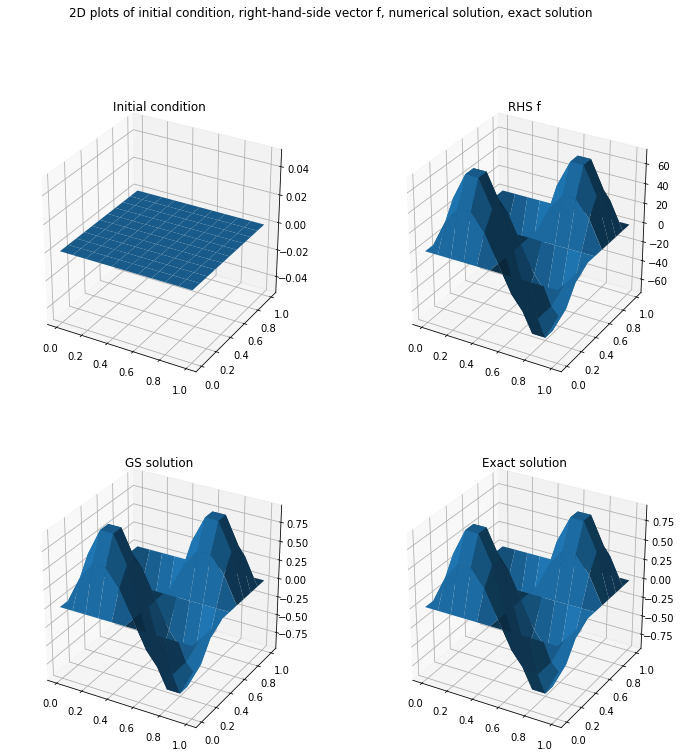

In [70]:
x = np.arange(0,1+1/N,h)
y = np.arange(0,1+1/N,h)
X,Y = np.meshgrid(x,y)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(2,2,1, projection='3d')
ax.plot_surface(X, Y, np.array(u0).reshape(N+1,N+1))
ax.set_title('Initial condition')

ax = fig.add_subplot(2,2,2, projection='3d')
ax.plot_surface(X, Y, np.array(f).reshape(N+1,N+1))
ax.set_title('RHS f')

ax = fig.add_subplot(2,2,3, projection='3d')
ax.plot_surface(X, Y, np.array(u).reshape(N+1,N+1))
ax.set_title('GS solution')

ax = fig.add_subplot(2,2,4, projection='3d')
ax.plot_surface(X, Y, np.array(u_ex).reshape(N+1,N+1))
ax.set_title('Exact solution')

fig.suptitle('2D plots of initial condition, right-hand-side vector f, numerical solution, exact solution')

plt.show()

### GS relaxation for $N=100$

In [71]:
N = 100
print('N =',N)
h = 1/N
v = 10000                   # max. number of Gauss-Seidel iterations

# making a 2D mesh and initializing it to zero
u0 = [0 for i in range((N+1)*(N+1))]
f = [0 for i in range((N+1)*(N+1))]
u_ex = [0 for i in range((N+1)*(N+1))]

# setting up f vector:      f(x,y) = 8.pi.pi.sin(2.pi.x).sin(2.pi.y)
for i in range(N+1):
    for j in range(N+1):
        f[i*(N+1)+j] = 8*math.pi*math.pi*math.sin(2*math.pi*i*h)*math.sin(2*math.pi*j*h)
        
# finding the solution approximation using Gauss-Seidel relaxation
u = gs(u0,f,v)

# compare with exact solution
for i in range(N+1):
    for j in range(N+1):
        u_ex[i*(N+1)+j] = math.sin(2*math.pi*i*h)*math.sin(2*math.pi*j*h)
print('Converged maximum error =', inf_dist(u,u_ex))

N = 100
GS relaxation converged in 8151 iterations. Residual =  9.997095811122463e-11
Converged maximum error = 0.00032910237548633425


#### Visuallization of inputs, output and exact solution 

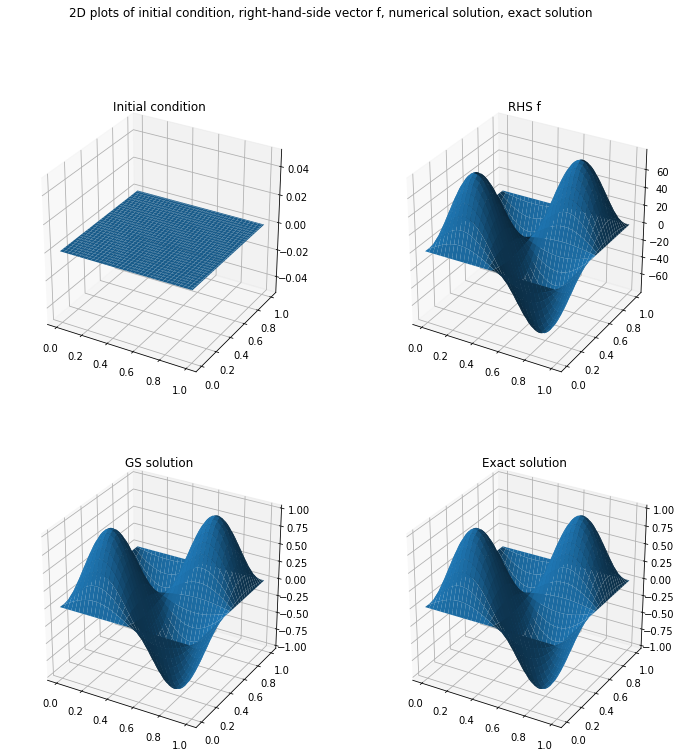

In [73]:
x = np.arange(0,1+1/N,h)
y = np.arange(0,1+1/N,h)
X,Y = np.meshgrid(x,y)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(2,2,1, projection='3d')
ax.plot_surface(X, Y, np.array(u0).reshape(N+1,N+1))
ax.set_title('Initial condition')

ax = fig.add_subplot(2,2,2, projection='3d')
ax.plot_surface(X, Y, np.array(f).reshape(N+1,N+1))
ax.set_title('RHS f')

ax = fig.add_subplot(2,2,3, projection='3d')
ax.plot_surface(X, Y, np.array(u).reshape(N+1,N+1))
ax.set_title('GS solution')

ax = fig.add_subplot(2,2,4, projection='3d')
ax.plot_surface(X, Y, np.array(u_ex).reshape(N+1,N+1))
ax.set_title('Exact solution')

fig.suptitle('2D plots of initial condition, right-hand-side vector f, numerical solution, exact solution')

plt.show()

## Restriction and Prolongation 

We have implemented fully weighted restriction operator in the function `restr(uh,Nc)` which loops over coarse mesh nodes and generates a coarse 2D mesh with halved number of mesh nodes in both dimensions. 

In [3]:
def restr(uh, Nc):
    N = int(Nc*2)
    u2h = [0 for i in range((Nc+1)*(Nc+1))]               # hard coded for zero-Dirichlet boundary condition 
    for i in range(1,Nc):
        ii = 2*i
        for j in range(1,Nc):
            jj = 2*j
            u2h[i*(Nc+1)+j] = (1/16)*(uh[(ii-1)*(N+1)+(jj-1)] + 2*uh[(ii)*(N+1)+(jj-1)] + uh[(ii+1)*(N+1)+(jj-1)] +
                                     2*uh[(ii-1)*(N+1)+(jj)] + 4*uh[(ii)*(N+1)+(jj)] + 2*uh[(ii+1)*(N+1)+(jj)] +
                                     uh[(ii-1)*(N+1)+(jj+1)] + 2*uh[(ii)*(N+1)+(jj+1)] + uh[(ii+1)*(N+1)+(jj+1)])
    return u2h

In [7]:
#####################################################################
#                    Restriction operator test 1
#####################################################################
N = 2**3

h = 1/N
u = [0 for i in range((N+1)*(N+1))]
for i in range(1,N):
    for j in range(1,N):
        u[i*(N+1)+j] = math.sin(2*math.pi*i*h)*math.sin(2*math.pi*j*h)

Nc = int(N/2)
u2h = restr(u,Nc)

h = 1/Nc
u2h_ex = [0 for i in range((Nc+1)*(Nc+1))]
for i in range(1,Nc):
    for j in range(1,Nc):
        u2h_ex[i*(Nc+1)+j] = math.sin(2*math.pi*i*h)*math.sin(2*math.pi*j*h)

#print(np.array(u2h).reshape(Nc+1,Nc+1))
#print(np.array(u2h_ex).reshape(Nc+1,Nc+1))

print('For N=2**4 \n||e2h||inf =', inf_dist(u2h, u2h_ex))

#####################################################################
#                    Restriction operator test 2
#####################################################################
print('----------------------------------------------------')

N = 2**7

h = 1/N
u = [0 for i in range((N+1)*(N+1))]
for i in range(1,N):
    for j in range(1,N):
        u[i*(N+1)+j] = math.sin(2*math.pi*i*h)*math.sin(2*math.pi*j*h)

Nc = int(N/2)
u2h = restr(u,Nc)

h = 1/Nc
u2h_ex = [0 for i in range((Nc+1)*(Nc+1))]
for i in range(1,Nc):
    for j in range(1,Nc):
        u2h_ex[i*(Nc+1)+j] = math.sin(2*math.pi*i*h)*math.sin(2*math.pi*j*h)

print('For N=2**7 \n||e2h||inf =', inf_dist(u2h, u2h_ex))

For N=2**4 
||e2h||inf = 0.27144660940672616
----------------------------------------------------
For N=2**7 
||e2h||inf = 0.0012041810633891536


We have implemented bilinear prolongation operator in the function `prolong(u2h,Nc)` which loops over coarse mesh nodes and generates a fine 2D mesh with doubled number of mesh nodes in both dimensions. 

In [5]:
def prolong(u2h, Nc):
    N = int(Nc*2)
    uh = [0 for i in range((N+1)*(N+1))]
    for i in range(1,Nc):
        ii = i*2
        for j in range(1,Nc):
            jj = j*2
            uh[(ii-1)*(N+1)+(jj-1)] += (1/8) * u2h[i*(Nc+1)+j]
            uh[(ii)*(N+1)+(jj-1)]   += (1/4) * u2h[i*(Nc+1)+j]
            uh[(ii+1)*(N+1)+(jj-1)] += (1/8) * u2h[i*(Nc+1)+j]
            uh[(ii-1)*(N+1)+(jj)]   += (1/4) * u2h[i*(Nc+1)+j]
            uh[(ii)*(N+1)+(jj)]     += (1/2) * u2h[i*(Nc+1)+j]
            uh[(ii+1)*(N+1)+(jj)]   += (1/4) * u2h[i*(Nc+1)+j]
            uh[(ii-1)*(N+1)+(jj+1)] += (1/8) * u2h[i*(Nc+1)+j]
            uh[(ii)*(N+1)+(jj+1)]   += (1/4) * u2h[i*(Nc+1)+j]
            uh[(ii+1)*(N+1)+(jj+1)] += (1/8) * u2h[i*(Nc+1)+j]
    return uh

In [6]:
#####################################################################
#                    Prolongation operator test 1
#####################################################################
N = 2**4

Nc = int(N/2)
h = 1/Nc
u2h = [0 for i in range((Nc+1)*(Nc+1))]
for i in range(1,Nc):
    for j in range(1,Nc):
        u2h[i*(Nc+1)+j] = math.sin(2*math.pi*i*h)*math.sin(2*math.pi*j*h)

uh = prolong(u2h,Nc)

uh_ex = [0 for i in range((N+1)*(N+1))]
h = 1/N
for i in range(1,N):
    for j in range(1,N):
        uh_ex[i*(N+1)+j] = math.sin(2*math.pi*i*h)*math.sin(2*math.pi*j*h)
        
print('For N=2**4 \n||e2h||inf =', inf_dist(uh, uh_ex))

#####################################################################
#                    Prolongation operator test 2
#####################################################################
print('----------------------------------------------------')

N = 2**7

Nc = int(N/2)
h = 1/Nc
u2h = [0 for i in range((Nc+1)*(Nc+1))]
for i in range(1,Nc):
    for j in range(1,Nc):
        u2h[i*(Nc+1)+j] = math.sin(2*math.pi*i*h)*math.sin(2*math.pi*j*h)

uh = prolong(u2h,Nc)

uh_ex = [0 for i in range((N+1)*(N+1))]
h = 1/N
for i in range(1,N):
    for j in range(1,N):
        uh_ex[i*(N+1)+j] = math.sin(2*math.pi*i*h)*math.sin(2*math.pi*j*h)

print('For N=2**7 \n||e2h||inf =', inf_dist(uh, uh_ex))

For N=2**4 
||e2h||inf = 0.5
----------------------------------------------------
For N=2**7 
||e2h||inf = 0.5


# Multigrid iterative solver

Multigrid iterative solver for our model Poisson equation has been implemented in the function `multiGrid(l,u0,f,gamma,v1,v2)`. The method combines pre-smoothing (parameter: `v1`), residual calculation, prolongation, error computation and correction (`gamma` controls type of correction cycle), and post-smoothing (parameter: `v2`).
We have used the same implementation of Gauss-Seidel relaxation as smoother for pre- and post smoothing in the function `smooth(u0,f,v)`. However, the convergence criterion has been removed from within GS smoother as we only use few iterations of the smoothing and convergence of Multigrid is relevant here. 

`driver_multiGrid(n,gamma,v1,v2,plot)` is the driver function for testing purpose equipped with convergence plots. `n` represents the exponent from $N=2^n$. `plot` takes the value of 1 (default) for plotting convergence against iterations and value of 2 for plotting convergence against runtime.

In [8]:
def smooth(u0, f, v):
    # u0 is the initial condition
    # f is the RHS side of the Poisson equation
    # v is the maximum number of iterations
    
    if len(u0)!=len(f):
        print("Dimensions of u0 and f do not match. Exiting smooth(u0,f,v).")
        return
    N = int(math.sqrt(len(f))-1)
    h = 1/N
    u = u0[:]
    
    for k in range(v):
        for i in range(1,N):
            for j in range(1,N):
                u[i*(N+1)+j] = 0.25*(h*h*f[i*(N+1)+j] + u[(i+1)*(N+1)+j] + u[(i-1)*(N+1)+j] + u[i*(N+1)+j+1] + u[i*(N+1)+j-1])
    return u

In [9]:
def multiGrid(l,u0,f,gamma,v1,v2):
    N = int(math.sqrt(len(u0))-1)
    h = 1/N
    
    # pre-smoothing
    u_bar = smooth(u0,f,v1)
    
    # residual calculation
    res_l = [0 for i in range((N+1)*(N+1))]
    for i in range(1,N):
        for j in range(1,N):
            res_l[i*(N+1)+j] = h*h*f[(i)*(N+1)+j] + u_bar[(i-1)*(N+1)+(j)] + u_bar[(i+1)*(N+1)+(j)] + u_bar[(i)*(N+1)+(j-1)] + u_bar[(i)*(N+1)+(j+1)]-4*u_bar[(i)*(N+1)+(j)]

    # restriction
    Nc = int(N/2)
    res_l_minus_1 = restr(res_l, Nc)
    
    err_l_minus_1 = [0 for i in range((Nc + 1)*(Nc + 1))]
    
    if (l==1):
        # termination of the recursion
        err_l_minus_1 = smooth(err_l_minus_1,constMult_vec(res_l_minus_1, -1),1)
    else:
        for k in range(gamma):
            err_l_minus_1, dummy = multiGrid(l-1,err_l_minus_1,constMult_vec(res_l_minus_1, -1),gamma,v1,v2)
    
    # prolongation
    err_l = prolong(err_l_minus_1,Nc)

    # correction and post smoothing
    u_l = smooth(sub_vec(u_bar,err_l),f,v2)

    return u_l, res_l

def driver_multiGrid(n,gamma,v1,v2,plot=1):
    N = 2**n
    h = 1/N
    l = n-1

    u = [0 for i in range((N+1)*(N+1))]
    f = [0 for i in range((N+1)*(N+1))]
    for i in range(N+1):
        for j in range(N+1):
            f[i*(N+1)+j] = 8*math.pi*math.pi*math.sin(2*math.pi*i*h)*math.sin(2*math.pi*j*h)

    
    count = 1
    res = []
    splittime = []

    start = time.time()
    u, res_vec = multiGrid(l,u,f,gamma,v1,v2)
    res.append(inf_norm(res_vec[1:-2]))
    splittime.append(time.time()-start)

    while (res[-1]>1e-5 and count<2000):          # max iteration bound
        u, res_vec = multiGrid(l,u,f,gamma,v1,v2)
        res.append(inf_norm(res_vec[1:-2]))
        splittime.append(time.time()-start)
        count += 1
        if count%100==0:
            print('Iteration: ', count, "\tResidual: ", res[-1])

    print('---------\nMultiGrid with gamma=',gamma,', v1=',v1,', v2=',v2,' for N=',N,' ran for ', count, ' iterations.',sep='')
    print('Residual =', res[-1])
    print('Time taken (sec) =',splittime[-1])
    u_ex = [0 for i in range((N+1)*(N+1))]
    for i in range(N+1):
        for j in range(N+1):
            u_ex[i*(N+1)+j] = math.sin(2*math.pi*i*h)*math.sin(2*math.pi*j*h)
    print('Converged maximum error =', inf_dist(u,u_ex))

    if plot==1:
        plt.semilogy(constMult_vec(res,1/res[0]))
        plt.xlabel('Iterations')
        plt.ylabel('Relative Residual')
        plt.show()
    
    if plot==2:
        plt.semilogy(splittime,constMult_vec(res,1/res[0]))
        plt.xlabel('Runtime')
        plt.ylabel('Relative Residual')
        plt.show()

## Standalone GS relaxation

For comparison, we start with running Gauss-Seidel relaxation as a standalone solver for the same model problem with $N=2^{7}$.

Iteration:  100 	Residual:  0.0037797959363387035
Iteration:  200 	Residual:  0.002974897616128569
Iteration:  300 	Residual:  0.002342888629950135
Iteration:  400 	Residual:  0.0018453379485476873
Iteration:  500 	Residual:  0.0014528142396308397
Iteration:  600 	Residual:  0.0011427933275061086
Iteration:  700 	Residual:  0.0008981114718218386
Iteration:  800 	Residual:  0.0007051732270442201
Iteration:  900 	Residual:  0.0005531815660750894
Iteration:  1000 	Residual:  0.0004335598170439603
Iteration:  1100 	Residual:  0.00034109977241136846
Iteration:  1200 	Residual:  0.00026923482431318035
Iteration:  1300 	Residual:  0.00021267519860979078
Iteration:  1400 	Residual:  0.0001681294331530303
Iteration:  1500 	Residual:  0.00013302105142720677
Iteration:  1600 	Residual:  0.0001053314401966432
Iteration:  1700 	Residual:  8.347774195005542e-05
Iteration:  1800 	Residual:  6.623020652885003e-05
Iteration:  1900 	Residual:  5.260139011742382e-05
Iteration:  2000 	Residual:  4.1819124

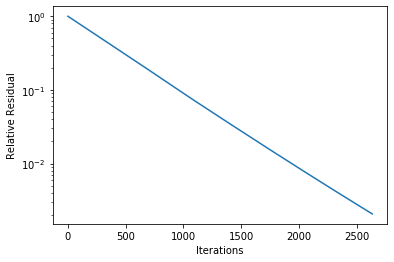

In [187]:
n = 7
N = 2**n
h = 1/N
v = 10000       # maximum iterations

u = [0 for i in range((N+1)*(N+1))]
f = [0 for i in range((N+1)*(N+1))]
for i in range(N+1):
    for j in range(N+1):
        f[i*(N+1)+j] = 8*math.pi*math.pi*math.sin(2*math.pi*i*h)*math.sin(2*math.pi*j*h)
u_ex = [0 for i in range((N+1)*(N+1))]
for i in range(N+1):
    for j in range(N+1):
        u_ex[i*(N+1)+j] = math.sin(2*math.pi*i*h)*math.sin(2*math.pi*j*h)

start = time.time()
count = 0
res = []
u = smooth(u,f,1)
res_vec = [0 for i in range((N+1)*(N+1))]
for i in range(1,N):
    for j in range(1,N):
        res_vec[i*(N+1)+j] = h*h*f[(i)*(N+1)+j] + u[(i-1)*(N+1)+(j)] + u[(i+1)*(N+1)+(j)] + u[(i)*(N+1)+(j-1)] + u[(i)*(N+1)+(j+1)]-4*u[(i)*(N+1)+(j)]
res.append(inf_norm(res_vec[1:-2]))
 
while (res[-1]>1e-5 and count<v):
    u = smooth(u,f,1)
    res_vec = [0 for i in range((N+1)*(N+1))]
    for i in range(1,N):
        for j in range(1,N):
            res_vec[i*(N+1)+j] = h*h*f[(i)*(N+1)+j] + u[(i-1)*(N+1)+(j)] + u[(i+1)*(N+1)+(j)] + u[(i)*(N+1)+(j-1)] + u[(i)*(N+1)+(j+1)]-4*u[(i)*(N+1)+(j)]

    res.append(inf_norm(res_vec[1:-2]))
    count += 1
    if count%100==0:
        print('Iteration: ', count, "\tResidual: ", res[-1])

end = time.time()

print('---------\nGauss-Seidel for N=',N,' ran for ', count, ' iterations.',sep='')
print('Residual =', res[-1])
print('Time taken (sec) =',end-start)
print('Converged maximum error =', inf_dist(u,u_ex))

plt.semilogy(constMult_vec(res,1/res[0]))
plt.xlabel('Iterations')
plt.ylabel('Relative Residual')
plt.show()

## Testing Multigrid

We tested the algorithm to get time of computation and convergence plots for different parameters. V- and W-cycles were tested by using `gamma` of 1 and 2 respectively. For each type of cycle, different `v1` and `v2`, which are pre- and post-smoothing iterations, were tested. Maximum levels of multi-grid were implemented by the algorithm till the grid is coarse enough for GS relaxation to be exact ($N=2$). All these tests were done twice each for $N=2^4$ and $N=2^7$, where dimensions of the Cartesian grid is $(N+1,N+1)$.

Additionally, the algorithm for $N=2^7$ was run with `gamma` of 3, 4 and 5 to monitor the increase in workload.

Then, we tested W-cycle with increasing number of smoothing iterations `v1` and `v2`.


### V-cycle $(\gamma=1)$

#### $N=2^4$ with $\nu_1=\nu_2=1$

---------
MultiGrid with gamma=1, v1=1, v2=1 for N=16 ran for 60 iterations.
Residual = 9.543125035982314e-06
Time taken (sec) = 0.1416163444519043
Converged maximum error = 0.01300971369257553


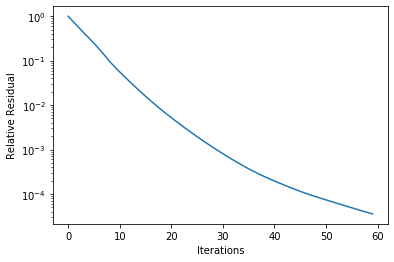

In [10]:
driver_multiGrid(4,1,1,1)

#### $N=2^4$ with $\nu_1=2$ and $\nu_2=1$

---------
MultiGrid with gamma=1, v1=2, v2=1 for N=16 ran for 40 iterations.
Residual = 9.371243596678624e-06
Time taken (sec) = 0.06981301307678223
Converged maximum error = 0.01300856670660977


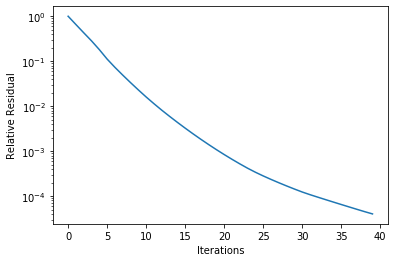

In [194]:
driver_multiGrid(4,1,2,1)

#### $N=2^7$ with $\nu_1=\nu_2=1$

Iteration:  100 	Residual:  0.002988810273728104
Iteration:  200 	Residual:  0.0018537496027182243
Iteration:  300 	Residual:  0.001147907572415452
Iteration:  400 	Residual:  0.0007082700484897231
Iteration:  500 	Residual:  0.00043542621356396083
Iteration:  600 	Residual:  0.0002703258134442166
Iteration:  700 	Residual:  0.00016878746688675506
Iteration:  800 	Residual:  0.00010572919852069873
Iteration:  900 	Residual:  6.64710136244473e-05
Iteration:  1000 	Residual:  4.196540640322155e-05
Iteration:  1100 	Residual:  2.6606926773364847e-05
Iteration:  1200 	Residual:  1.6949451485004374e-05
Iteration:  1300 	Residual:  1.0854546036220825e-05
---------
MultiGrid with gamma=1, v1=1, v2=1 for N=128 ran for 1319 iterations.
Residual = 9.979725169806386e-06
Time taken (sec) = 164.9775607585907
Converged maximum error = 0.0021572519674115664


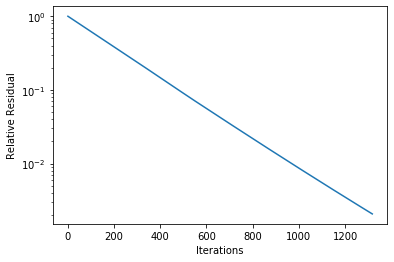

In [214]:
driver_multiGrid(7,1,1,1)

Iteration:  100 	Residual:  0.0029889800061910776
Iteration:  200 	Residual:  0.0018539601893405866
Iteration:  300 	Residual:  0.001148105216878914
Iteration:  400 	Residual:  0.0007084344500638551
Iteration:  500 	Residual:  0.0004355539462652658
Iteration:  600 	Residual:  0.00027041781902292783
Iteration:  700 	Residual:  0.000168853894838783
Iteration:  800 	Residual:  0.00010577630178731923
Iteration:  900 	Residual:  6.650388832429854e-05
Iteration:  1000 	Residual:  4.1988203749898645e-05
Iteration:  1100 	Residual:  2.6622624011984897e-05
Iteration:  1200 	Residual:  1.696020563546341e-05
Iteration:  1300 	Residual:  1.0861889319979667e-05
---------
MultiGrid with gamma=1, v1=1, v2=1 for N=128 ran for 1319 iterations.
Residual = 9.986553307861357e-06
Time taken (sec) = 171.80051565170288
Converged maximum error = 0.00215875824151901


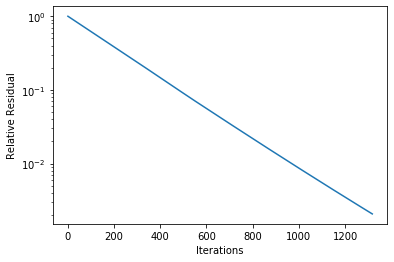

In [11]:
driver_multiGrid(7,1,1,1)

#### $N=2^7$ with $\nu_1=2$ and $\nu_2=1$

Iteration:  100 	Residual:  0.0023537083562645833
Iteration:  200 	Residual:  0.001147910075861791
Iteration:  300 	Residual:  0.0005555888139765486
Iteration:  400 	Residual:  0.00027032684189221
Iteration:  500 	Residual:  0.00013353312006980644
Iteration:  600 	Residual:  6.647135474713295e-05
Iteration:  700 	Residual:  3.3396605538360546e-05
Iteration:  800 	Residual:  1.6949557236856094e-05
---------
MultiGrid with gamma=1, v1=2, v2=1 for N=128 ran for 880 iterations.
Residual = 9.935811383865456e-06
Time taken (sec) = 120.18285417556763
Converged maximum error = 0.002147368850494602


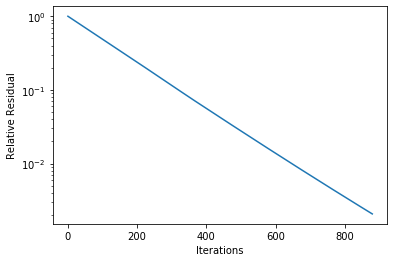

In [199]:
driver_multiGrid(7,1,2,1)

### W-cycle $(\gamma=2)$

#### $N=2^4$ with $\nu_1=\nu_2=1$

---------
MultiGrid with gamma=2, v1=1, v2=1 for N=16 ran for 59 iterations.
Residual = 9.74816852428173e-06
Time taken (sec) = 0.12566113471984863
Converged maximum error = 0.013010943593477542


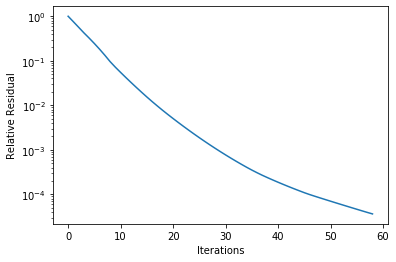

In [197]:
driver_multiGrid(4,2,1,1)

#### $N=2^4$ with $\nu_1=2$ and $\nu_2=1$

---------
MultiGrid with gamma=2, v1=2, v2=1 for N=16 ran for 40 iterations.
Residual = 9.088845882687657e-06
Time taken (sec) = 0.14760231971740723
Converged maximum error = 0.013006773430059404


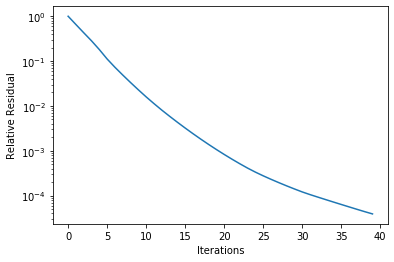

In [200]:
driver_multiGrid(4,2,2,1)

#### $N=2^7$ with $\nu_1=\nu_2=1$

Iteration:  100 	Residual:  0.0029884769559371804
Iteration:  200 	Residual:  0.0018533357968069097
Iteration:  300 	Residual:  0.0011475192239340792
Iteration:  400 	Residual:  0.0007079470863255999
Iteration:  500 	Residual:  0.0004351753482865206
Iteration:  600 	Residual:  0.0002701451574633751
Iteration:  700 	Residual:  0.0001686570261396625
Iteration:  800 	Residual:  0.0001056366988567703
Iteration:  900 	Residual:  6.640644742494928e-05
Iteration:  1000 	Residual:  4.192062861818613e-05
Iteration:  1100 	Residual:  2.6576091793462098e-05
Iteration:  1200 	Residual:  1.6928324028331332e-05
Iteration:  1300 	Residual:  1.0840117498300827e-05
---------
MultiGrid with gamma=2, v1=1, v2=1 for N=128 ran for 1319 iterations.
Residual = 9.96630842831081e-06
Time taken (sec) = 216.77089738845825
Converged maximum error = 0.0021542896781417964


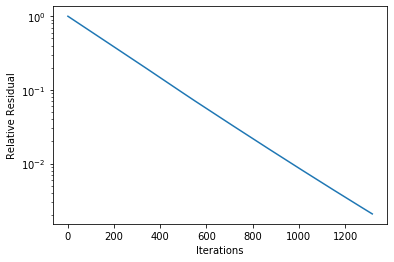

In [201]:
driver_multiGrid(7,2,1,1)

#### $N=2^7$ with $\nu_1=2$ and $\nu_2=1$

Iteration:  100 	Residual:  0.00235332069716776
Iteration:  200 	Residual:  0.0011475278157213609
Iteration:  300 	Residual:  0.0005553066488137581
Iteration:  400 	Residual:  0.00027014892259824563
Iteration:  500 	Residual:  0.00013342469793320433
Iteration:  600 	Residual:  6.640772464816536e-05
Iteration:  700 	Residual:  3.3359948957922825e-05
Iteration:  800 	Residual:  1.6928724665188355e-05
---------
MultiGrid with gamma=2, v1=2, v2=1 for N=128 ran for 879 iterations.
Residual = 9.98859794298923e-06
Time taken (sec) = 174.40359234809875
Converged maximum error = 0.0021592988438051686


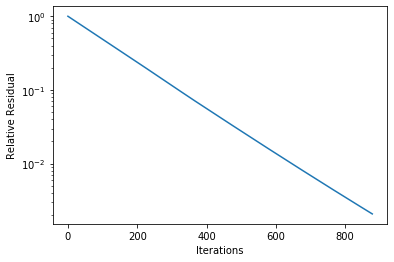

In [202]:
driver_multiGrid(7,2,2,1)

### Varying $\gamma=3,4,5$ for $N=2^7$

As $\gamma$ is increased, the workload for the Multigrid also increases exponentially (number of error corrections at each level is higher). This means that each iteration becomes more computationally intensive and takes more time. However, we also get the faster convergence with respect to number of iterations. In our case, V- and W-cycle, with $\gamma=1,2$ respectively perform almost similarly. We stick with W-cycle for further experiments due to similar workload as V-cyle but slightly higher error correction rate with respect to iterations.

However, if we go to higher `gamma` values, convergence with respect to iterations does not change, but each iteration becomes pretty expensive. For `gamma=3,4,5`, we got convergence in 879 iterations, whereas the time of computation was around 300, 500 and 860 seconds repectively.

Iteration:  100 	Residual:  0.0023529434844991037
Iteration:  200 	Residual:  0.0011471557656874687
Iteration:  300 	Residual:  0.000555032157398827
Iteration:  400 	Residual:  0.0002699759260105239
Iteration:  500 	Residual:  0.00013331925850890158
Iteration:  600 	Residual:  6.634582813536127e-05
Iteration:  700 	Residual:  3.3324283025049084e-05
Iteration:  800 	Residual:  1.6908449248731472e-05
---------
MultiGrid with gamma=3, v1=2, v2=1 for N=128 ran for 879 iterations.
Residual = 9.975690930197345e-06
Time taken (sec) = 303.77285718917847
Converged maximum error = 0.0021564425174290802


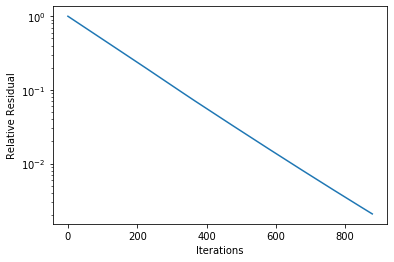

Iteration:  100 	Residual:  0.0023525765095815387
Iteration:  200 	Residual:  0.0011467937418556673
Iteration:  300 	Residual:  0.0005547652001220982
Iteration:  400 	Residual:  0.0002698077556537726
Iteration:  500 	Residual:  0.0001332167429177744
Iteration:  600 	Residual:  6.628563083932448e-05
Iteration:  700 	Residual:  3.3289587972440415e-05
Iteration:  800 	Residual:  1.6888719820418174e-05
---------
MultiGrid with gamma=4, v1=2, v2=1 for N=128 ran for 879 iterations.
Residual = 9.963127797885107e-06
Time taken (sec) = 496.1879892349243
Converged maximum error = 0.0021536585096789684


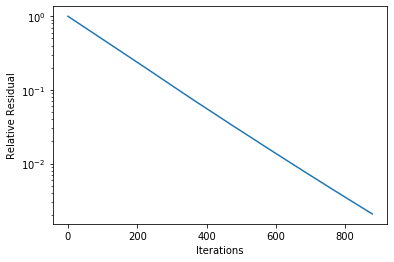

Iteration:  100 	Residual:  0.0023522195530505385
Iteration:  200 	Residual:  0.001146441548113497
Iteration:  300 	Residual:  0.0005545056278726257
Iteration:  400 	Residual:  0.00026964430923293037
Iteration:  500 	Residual:  0.0001331170888692057
Iteration:  600 	Residual:  6.622709651926684e-05
Iteration:  700 	Residual:  3.3255843017609976e-05
Iteration:  800 	Residual:  1.6869524671392355e-05
---------
MultiGrid with gamma=5, v1=2, v2=1 for N=128 ran for 879 iterations.
Residual = 9.950901178168436e-06
Time taken (sec) = 867.6183941364288
Converged maximum error = 0.002150945332641707


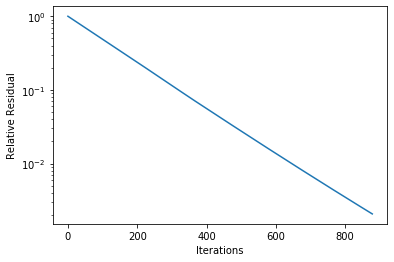

In [205]:
driver_multiGrid(7,3,2,1)
driver_multiGrid(7,4,2,1)
driver_multiGrid(7,5,2,1)

### Varying smoothing iterations for $N=2^7$ and W-cycle

Increasing the smoothing iterations lead to more computation per multigrid iteration. This can lead to converged solution in less multigrid iterations, however the effect might not be very profound when runtime is considered. Same can be seen in the following tests where number of multigrid iterations decreased by 60%, whereas the computation time decreased by only 25%, when going from smoothing iterations of 2 to 5.

#### $\nu_1=2, \nu_2=2$

Iteration:  100 	Residual:  0.0018577854010346506
Iteration:  200 	Residual:  0.0007096781988882306
Iteration:  300 	Residual:  0.00027079154915909953
Iteration:  400 	Residual:  0.00010588681238665743
Iteration:  500 	Residual:  4.201842837625591e-05
Iteration:  600 	Residual:  1.696710847332028e-05
---------
MultiGrid with gamma=2, v1=2, v2=2 for N=128 ran for 660 iterations.
Residual = 9.94480564076028e-06
Time taken (sec) = 164.52043914794922
Converged maximum error = 0.002144504713806117


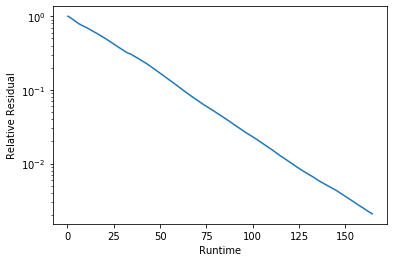

In [207]:
driver_multiGrid(7,2,2,2,2)

#### $\nu_1=3, \nu_2=2$

Iteration:  100 	Residual:  0.0014624933303721832
Iteration:  200 	Residual:  0.0004362545445646404
Iteration:  300 	Residual:  0.00013374143954614226
Iteration:  400 	Residual:  4.201928136815525e-05
Iteration:  500 	Residual:  1.3568130585284166e-05
---------
MultiGrid with gamma=2, v1=3, v2=2 for N=128 ran for 528 iterations.
Residual = 9.945048906168097e-06
Time taken (sec) = 153.15263986587524
Converged maximum error = 0.0021445536361045514


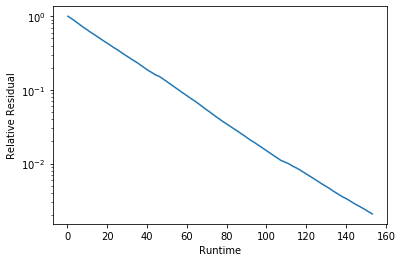

In [208]:
driver_multiGrid(7,2,3,2,2)

#### $\nu_1=3, \nu_2=3$

Iteration:  100 	Residual:  0.0011530848653773518
Iteration:  200 	Residual:  0.00027143930663608984
Iteration:  300 	Residual:  6.671885583697801e-05
Iteration:  400 	Residual:  1.7005963960148307e-05
---------
MultiGrid with gamma=2, v1=3, v2=3 for N=128 ran for 440 iterations.
Residual = 9.967270747424095e-06
Time taken (sec) = 140.46838331222534
Converged maximum error = 0.0021446022384615793


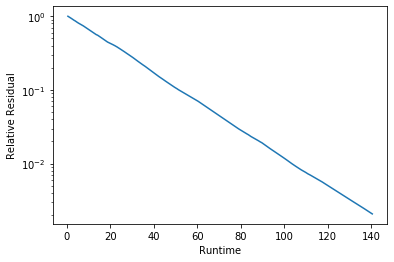

In [209]:
driver_multiGrid(7,2,3,3,2)

#### $\nu_1=4, \nu_2=3$

Iteration:  100 	Residual:  0.0009061370604763752
Iteration:  200 	Residual:  0.0001694634556259622
Iteration:  300 	Residual:  3.351508775439882e-05
---------
MultiGrid with gamma=2, v1=4, v2=3 for N=128 ran for 377 iterations.
Residual = 9.989550027178495e-06
Time taken (sec) = 131.004408121109
Converged maximum error = 0.0021495874649942737


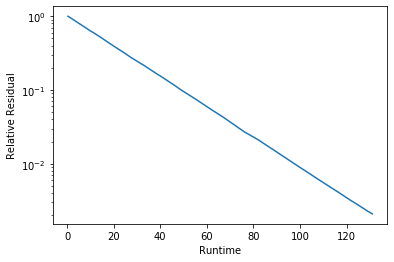

In [210]:
driver_multiGrid(7,2,4,3,2)

#### $\nu_1=4, \nu_2=4$

Iteration:  100 	Residual:  0.0007131518408893811
Iteration:  200 	Residual:  0.00010638855442257622
Iteration:  300 	Residual:  1.7044891132300677e-05
---------
MultiGrid with gamma=2, v1=4, v2=4 for N=128 ran for 330 iterations.
Residual = 9.989776120100657e-06
Time taken (sec) = 130.4900767803192
Converged maximum error = 0.002144697467335921


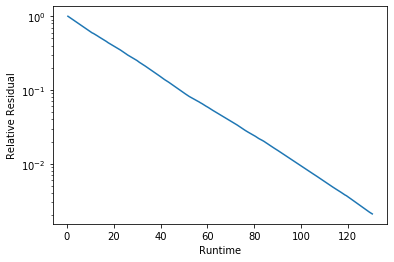

In [211]:
driver_multiGrid(7,2,4,4,2)

#### $\nu_1=5, \nu_2=4$

Iteration:  100 	Residual:  0.0005594077147197396
Iteration:  200 	Residual:  6.687671209792967e-05
---------
MultiGrid with gamma=2, v1=5, v2=4 for N=128 ran for 294 iterations.
Residual = 9.858503589033063e-06
Time taken (sec) = 124.78000020980835
Converged maximum error = 0.0021153454575055797


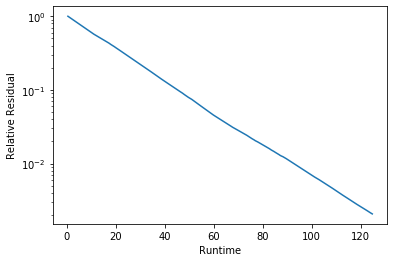

In [212]:
driver_multiGrid(7,2,5,4,2)

#### $\nu_1=5, \nu_2=5$

Iteration:  100 	Residual:  0.00043948552631478677
Iteration:  200 	Residual:  4.2312961614943134e-05
---------
MultiGrid with gamma=2, v1=5, v2=5 for N=128 ran for 265 iterations.
Residual = 9.793638163113627e-06
Time taken (sec) = 123.26672554016113
Converged maximum error = 0.00209600636990237


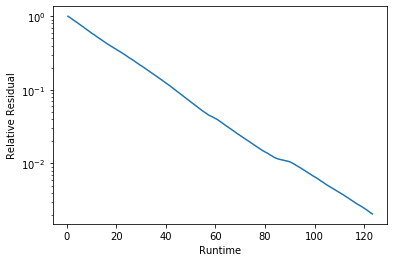

In [213]:
driver_multiGrid(7,2,5,5,2)

# Remarks

In this study, we interestingly found Gauss-Seidel (GS) standalone giving faster runtime for N=128 than Multigrid with W-cyle.  While number of iterations taken by GS standalone to converge (2636) is almost 2-3 times than Multigrid, each iteration is significantly less expensive. However, Multigrid with V-cycle is faster than both W-cycle and GS standalone. 

This might be because of the workload overhead in Multigrid which is magnified in Python-interpreter environment. Using a compiler based enviroment might bring this overhead down after using compiler optimizations, leading to faster runtimes. 